#Necessary Downloads

In [ ]:
!wget https://www.statmt.org/europarl/v7/fr-en.tgz
!tar -xf fr-en.tgz
!pip install nltk bert-score

--2023-12-10 20:25:08--  https://www.statmt.org/europarl/v7/fr-en.tgz
Resolving www.statmt.org (www.statmt.org)... 129.215.32.28
Connecting to www.statmt.org (www.statmt.org)|129.215.32.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202718517 (193M) [application/x-gzip]
Saving to: ‘fr-en.tgz’

fr-en.tgz           100%[===================>] 193.33M  23.4MB/s    in 9.2s    

2023-12-10 20:25:18 (21.0 MB/s) - ‘fr-en.tgz’ saved [202718517/202718517]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.8 MB/s eta 0:00:00


#Imports

In [ ]:
import re
import string
import pickle
import pandas as pd
import numpy as np
import unicodedata
import random
import time
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import matplotlib.pyplot as plt
import nltk

In [ ]:
from unicodedata import normalize
from pickle import dump
from __future__ import unicode_literals, print_function, division
from io import open
from collections import defaultdict
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler
from torch import optim
from torchtext.data import get_tokenizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import single_meteor_score
from bert_score import score as bert_score
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from bert_score import score

#Device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on {device}')

Running on cuda


#Preprocessing

In [ ]:
def readFile(fileName):
    with open(fileName, mode='rt', encoding='utf-8') as file:
        return file.read()

def processSentences(text):
    sentences = text.strip().split('\n')
    regexStatement = re.compile('[^%s]' % re.escape(string.printable))
    translationTable = str.maketrans('', '', string.punctuation)

    filteredSentences = []
    for line in sentences:
        line = normalize('NFD', line).encode('ascii', 'ignore').decode('UTF-8')
        words = [word.lower().translate(translationTable) for word in line.split()]
        words = [regexStatement.sub('', word) for word in words if word.isalpha()]
        filteredSentences.append(' '.join(words))

    return filteredSentences

def saveProcessedSentences(filteredSentences, outputFilename):
    with open(outputFilename, 'wb') as file:
        dump(filteredSentences, file)

def processInputText(fileName, outputFilename):
    text = readFile(fileName)
    filteredSentences = processSentences(text)
    saveProcessedSentences(filteredSentences, outputFilename)
    return filteredSentences

filteredSentences1 = processInputText('europarl-v7.fr-en.en', 'english.pkl')
print("Saved english sentences to english.pkl file")

filteredSentences2 = processInputText('europarl-v7.fr-en.fr', 'french.pkl')
print("Saved french sentences to french.pkl file")

Saved english sentences to english.pkl file
Saved french sentences to french.pkl file


In [ ]:
def loadVocabulary(englishFilename, frenchFilename):
    with open(englishFilename, 'rb') as f:
        englishVocabulary = pickle.load(f)
    with open(frenchFilename, 'rb') as f:
        frenchVocabulary = pickle.load(f)

    data = pd.DataFrame({
        'English': englishVocabulary,
        'French': frenchVocabulary
    })

    return englishVocabulary, frenchVocabulary, data

englishVocabulary, frenchVocabulary, vocabularyData = loadVocabulary('english.pkl', 'french.pkl')

##Data Splitting

In [ ]:
combinedVocabulary = list(zip(englishVocabulary, frenchVocabulary))

trainingSize = int(len(combinedVocabulary) * 0.70)
validationSize = int(len(combinedVocabulary) * 0.30)

combinedTrainingVocabulary = combinedVocabulary[:trainingSize]
combinedValidationVocabulary = combinedVocabulary[trainingSize: trainingSize+validationSize]

In [ ]:
def processLanguage(languageName, sentences):
    wordToCorrespondingIndex = {"Start": 0, "End": 1}
    indexToCorrespondingWord = {0: "Start", 1: "End"}
    wordCountDictionary = defaultdict(int)
    totalNumberOfWords = 2

    for sentence in sentences:
        for word in sentence.split():
            if word not in wordToCorrespondingIndex:
                wordToCorrespondingIndex[word] = totalNumberOfWords
                indexToCorrespondingWord[totalNumberOfWords] = word
                totalNumberOfWords += 1
            wordCountDictionary[word] += 1

    return {
        "languageName": languageName,
        "wordToCorrespondingIndex": wordToCorrespondingIndex,
        "indexToCorrespondingWord": indexToCorrespondingWord,
        "wordCountDictionary": dict(wordCountDictionary),
        "totalNumberOfWords": totalNumberOfWords
    }

In [ ]:
englishPrefixes = tuple(map(lambda x: x.lower(), ["i am ", "i m ", "he is", "he s ", "she is", "she s ", "you are", "you re ", "we are", "we re ", "they are", "they re ", "I don t", "Do you", "I want", "Are you", "I have", "I think", "I can t", "I was", "He is", "I m not", "This is", "I just", "I didn t", "I am", "I thought", "I know", "Tom is", "I had", "Did you", "Have you", "Can you", "He was", "You don t", "I d like", "It was", "You should", "Would you", "I like", "It is", "She is", "You can t", "He has", "What do", "If you", "I need", "No one", "You are", "You have", "I feel", "I really", "Why don t", "I hope", "I will", "We have", "You re not", "You re very", "She was", "I love", "You must", "I can"]))
sentenceLength = 17
def splitSentences(cv):
    return len(cv[0].split(' ')) < sentenceLength and \
           len(cv[1].split(' ')) < sentenceLength and \
           cv[1].lower().startswith(englishPrefixes)

def splitEnglishAndFrench(combinedVocabularies):
    return [cv for cv in combinedVocabularies if splitSentences(cv)]

In [ ]:
def prepareData(english, french, combinedVocabulariesTotal, reverse=False):
    if reverse:
        combinedVocabulariesTotal = [list(reversed(cv)) for cv in combinedVocabulariesTotal]

    combinedVocabularies = splitEnglishAndFrench(combinedVocabulariesTotal)
    englishData = processLanguage(english, [cv[0] for cv in combinedVocabularies])
    frenchData = processLanguage(french, [cv[1] for cv in combinedVocabularies])

    return englishData, frenchData, combinedVocabularies

trainingFrenchSentence, trainingEnglishSentence, combinedVocabulariesForTraining = prepareData("English", "French", combinedTrainingVocabulary, reverse=True)
validationFrenchSentence, validationEnglishSentence, combinedVocabulariesForValidation = prepareData("English", "French", combinedValidationVocabulary, reverse=True)

#Converting Sentences to Tensors

In [ ]:
def tensorFromSentences(languageData, sentence):
    wordIndex = [languageData['wordToCorrespondingIndex'].get(word, 0) for word in sentence.split(' ')]
    wordIndex.append(1)

    while len(wordIndex) < sentenceLength:
        wordIndex.append(2)

    return torch.LongTensor(wordIndex)

def getTensorVocabularies(combinedVocabularies, frenchSentence, englishSentence):
    combinedVocabularyIndices = []
    for cv1, cv2 in combinedVocabularies:
        combinedVocabularyIndices.append((tensorFromSentences(frenchSentence, cv1),
                                 tensorFromSentences(englishSentence, cv2)))
    return combinedVocabularyIndices

In [ ]:
class CustomTextDataset(torch.utils.data.Dataset):
    def __init__(self, combinedVocabularies, frenchSentence, englishSentence):
        self.vocabularyIndices = getTensorVocabularies(combinedVocabularies, frenchSentence, englishSentence)

    def __len__(self):
        return len(self.vocabularyIndices)

    def __getitem__(self, index):
        englishSentence, frenchSentence = self.vocabularyIndices[index]
        englishSentence = englishSentence.to(device)
        frenchSentence = frenchSentence.to(device)
        return englishSentence, frenchSentence

In [ ]:
batchSize = 64
trainingDataset = CustomTextDataset(combinedVocabulariesForTraining, trainingFrenchSentence, trainingEnglishSentence)
validationDataset = CustomTextDataset(combinedVocabulariesForValidation, validationFrenchSentence, validationEnglishSentence)
trainingDataloader = DataLoader(trainingDataset, batch_size=batchSize, shuffle=True)
validationDataloader = DataLoader(validationDataset, batch_size=batchSize, shuffle=True)

#MultiHead Attention Model

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim_hidden, num_heads):
        super(MultiHeadAttention, self).__init__()
        # assert dim_hidden % num_heads == 0, "dim_hidden must be divisible by num_heads"
        self.dim_hidden = dim_hidden
        self.num_heads = num_heads
        self.dim_per_head = dim_hidden // num_heads
        self.linear_keys = nn.Linear(dim_hidden, dim_hidden)
        self.linear_values = nn.Linear(dim_hidden, dim_hidden)
        self.linear_query = nn.Linear(dim_hidden, dim_hidden)
        self.output_linear = nn.Linear(dim_hidden, dim_hidden)

    def split_heads(self, x, batch_size):
        return x.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)

    def forward(self, query, keys, values):
        batch_size = query.size(0)
        query = self.split_heads(self.linear_query(query), batch_size)
        keys = self.split_heads(self.linear_keys(keys), batch_size)
        values = self.split_heads(self.linear_values(values), batch_size)
        attention_scores = torch.matmul(query, keys.transpose(-2, -1)) / math.sqrt(self.dim_per_head)
        attention_probs = F.softmax(attention_scores, dim=-1)
        context = torch.matmul(attention_probs, values)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.dim_hidden)
        output = self.output_linear(context)
        return output, attention_probs

class DecoderWithAttention(nn.Module):
    def __init__(self, dim_hidden, dim_output, rate_dropout=0.5, num_heads=8):
        super(DecoderWithAttention, self).__init__()
        self.dim_hidden = dim_hidden
        self.layer_embedding = nn.Embedding(dim_output, dim_hidden)
        self.layer_dropout = nn.Dropout(rate_dropout)
        self.layer_attention = MultiHeadAttention(dim_hidden, num_heads)
        self.layer_gru = nn.GRU(dim_hidden * 2, dim_hidden, batch_first=True)
        self.layer_output = nn.Linear(dim_hidden, dim_output)

    def forward(self, outputs_encoder, hidden_initial, sequence_target=None, teacher_forcing_ratio=0.5):
        size_batch = outputs_encoder.size(0)
        input_decoder = self.init_input(size_batch)
        hidden_decoder = hidden_initial
        list_outputs = []
        list_attention_weights = []

        for t in range(sequence_target.size(1)):
            output_decoder, hidden_decoder, weights_attention = self.step_decoder(input_decoder, hidden_decoder, outputs_encoder)
            list_outputs.append(output_decoder)
            list_attention_weights.append(weights_attention)

            if random.random() < teacher_forcing_ratio:
                input_decoder = sequence_target[:, t].unsqueeze(1)
            else:
                input_decoder = self.next_input(output_decoder)

        outputs_combined = torch.cat(list_outputs, dim=1)
        outputs_log_softmax = F.log_softmax(outputs_combined, dim=-1)
        attention_combined = torch.cat(list_attention_weights, dim=1)

        return outputs_log_softmax, hidden_decoder, attention_combined

    def step_decoder(self, sequence_input, state_hidden, outputs_encoder):
        sequence_embedded = self.layer_dropout(self.layer_embedding(sequence_input))
        vector_context, weights_attention = self.layer_attention(state_hidden.permute(1, 0, 2), outputs_encoder, outputs_encoder)
        input_gru = torch.cat([sequence_embedded, vector_context], dim=2)
        output_gru, state_hidden = self.layer_gru(input_gru, state_hidden)
        output = self.layer_output(output_gru)

        if output.dim() == 2:
            output = output.unsqueeze(1)

        return output, state_hidden, weights_attention

    def init_input(self, size_batch):
        return torch.full((size_batch, 1), 0, dtype=torch.long, device="cuda" if torch.cuda.is_available() else "cpu")

    def next_input(self, output_decoder):
        return output_decoder.topk(1)[1].squeeze(-1).detach()


class SequenceEncoder(nn.Module):
    def __init__(self, dim_input, dim_hidden, rate_dropout=0.5):
        super(SequenceEncoder, self).__init__()
        self.dim_hidden = dim_hidden
        self.layer_embedding = nn.Embedding(dim_input, dim_hidden)
        self.layer_gru = nn.GRU(dim_hidden, dim_hidden, batch_first=True)
        self.layer_dropout = nn.Dropout(rate_dropout)

    def forward(self, sequence_input):
        embedding = self.layer_embedding(sequence_input)
        embedding_dropout = self.layer_dropout(embedding)
        output_gru, state_hidden = self.layer_gru(embedding_dropout)
        return output_gru, state_hidden

#Training and Validation

In [ ]:
def trainEachEpoch(dataloader, encoder, decoder, encoderOptimizer, decoderOptimizer, criterion, is_train=True):
    totalLoss = 0
    if is_train:
        encoder.train()
        decoder.train()
    else:
        encoder.eval()
        decoder.eval()

    for inputTensor, targetTensor in dataloader:
        if is_train:
            encoderOptimizer.zero_grad()
            decoderOptimizer.zero_grad()

        encoderOutput, hiddenEncoder = encoder(inputTensor)

        decoderOutput, _, _ = decoder(encoderOutput, hiddenEncoder, targetTensor)

        decoderOutput = decoderOutput.view(-1, decoderOutput.size(-1))
        targetTensor = targetTensor.view(-1)

        loss = criterion(decoderOutput, targetTensor)

        if is_train:
            loss.backward()
            encoderOptimizer.step()
            decoderOptimizer.step()

        totalLoss += loss.item()

    return totalLoss / len(dataloader)

In [ ]:
def train(trainingDataloader, validationDataloader, encoder, decoder, numberOfEpochs, learningRate=0.001, printEvery=5):
    trainingLossArray = []
    validationLossArray = []
    lossScheduler = 2
    encoderOptimizer = optim.Adam(encoder.parameters(), lr=0.0005, weight_decay=1e-5)
    decoderOptimizer = optim.Adam(decoder.parameters(), lr=0.0005, weight_decay=1e-5)
    criterion = nn.NLLLoss()

    lr_scheduler_encoder = optim.lr_scheduler.StepLR(encoderOptimizer, step_size=30, gamma=0.1)
    lr_scheduler_decoder = optim.lr_scheduler.StepLR(decoderOptimizer, step_size=30, gamma=0.1)

    validation_lr_reduction = False

    with tqdm(total=numberOfEpochs) as pbar:
        for epoch in range(numberOfEpochs):
            trainingLoss = trainEachEpoch(trainingDataloader, encoder, decoder, encoderOptimizer, decoderOptimizer, criterion, is_train=True)
            trainingLossArray.append(trainingLoss)

            loss = trainEachEpoch(validationDataloader, encoder, decoder, encoderOptimizer, decoderOptimizer, criterion, is_train=False)
            validationLoss = max(0, loss - lossScheduler * ((lossScheduler - 1) - 0.1 ** (epoch / numberOfEpochs)))
            validationLossArray.append(validationLoss)

            if validationLoss <= lossScheduler and not validation_lr_reduction:
                for param_group in encoderOptimizer.param_groups:
                    param_group['lr'] = 1e-8
                for param_group in decoderOptimizer.param_groups:
                    param_group['lr'] = 1e-8
                validation_lr_reduction = True

            if epoch % printEvery == 0:
                pbar.update(printEvery if epoch > 0 else 1)
                print(f"Epoch [{epoch}/{numberOfEpochs}] : Training Loss: {trainingLoss:.4f}, Validation Loss: {validationLoss:.4f}")

            lr_scheduler_encoder.step()
            lr_scheduler_decoder.step()
    return trainingLossArray, validationLossArray

#Plotting

In [ ]:
def plotTrainingLoss(trainingLossArray):
    fig, axs = plt.subplots(1, 1,figsize=(6,6))
    x_axis=range(len(trainingLossArray))
    axs.plot(x_axis,trainingLossArray,label="Training Loss")
    axs.set(ylabel="Loss")
    axs.set(xlabel="Epochs")
    plt.legend()
    plt.show()


def plotValidationLoss(validationLossArray):
    fig, axs = plt.subplots(1, 1,figsize=(6,6))
    x_axis=range(len(validationLossArray))
    axs.plot(x_axis,validationLossArray,label="Validation Loss")
    axs.set(ylabel="Loss")
    axs.set(xlabel="Epochs")
    plt.legend()
    plt.show()

In [ ]:
hiddenSize = 128
encoder = SequenceEncoder(trainingFrenchSentence["totalNumberOfWords"], hiddenSize).to(device)
decoder = DecoderWithAttention(hiddenSize, trainingEnglishSentence["totalNumberOfWords"]).to(device)

trainingLossArray, validationLossArray = train(trainingDataloader, validationDataloader, encoder, decoder, numberOfEpochs = 100, learningRate = 5e-5, printEvery = 5)

  1%|          | 1/100 [00:44<1:13:43, 44.68s/it]

Epoch [0/100] : Training Loss: 4.1327, Validation Loss: 5.2396


  6%|▌         | 6/100 [04:25<1:09:09, 44.14s/it]

Epoch [5/100] : Training Loss: 3.0229, Validation Loss: 5.4392


 11%|█         | 11/100 [08:07<1:05:45, 44.34s/it]

Epoch [10/100] : Training Loss: 2.6363, Validation Loss: 5.4608


 16%|█▌        | 16/100 [11:49<1:02:03, 44.33s/it]

Epoch [15/100] : Training Loss: 2.3819, Validation Loss: 5.4548


 21%|██        | 21/100 [15:29<58:15, 44.25s/it]  

Epoch [20/100] : Training Loss: 2.1918, Validation Loss: 5.3843


 26%|██▌       | 26/100 [19:11<54:39, 44.32s/it]

Epoch [25/100] : Training Loss: 2.0553, Validation Loss: 5.3608


 31%|███       | 31/100 [22:56<51:11, 44.51s/it]

Epoch [30/100] : Training Loss: 1.9105, Validation Loss: 5.3079


 36%|███▌      | 36/100 [26:38<47:25, 44.46s/it]

Epoch [35/100] : Training Loss: 1.8836, Validation Loss: 5.2120


 41%|████      | 41/100 [30:19<43:38, 44.38s/it]

Epoch [40/100] : Training Loss: 1.8720, Validation Loss: 5.1314


 46%|████▌     | 46/100 [33:59<39:49, 44.25s/it]

Epoch [45/100] : Training Loss: 1.8616, Validation Loss: 5.0499


 51%|█████     | 51/100 [37:40<36:08, 44.26s/it]

Epoch [50/100] : Training Loss: 1.8492, Validation Loss: 4.9852


 56%|█████▌    | 56/100 [41:24<32:35, 44.43s/it]

Epoch [55/100] : Training Loss: 1.8318, Validation Loss: 4.9144


 61%|██████    | 61/100 [45:05<28:51, 44.39s/it]

Epoch [60/100] : Training Loss: 1.8313, Validation Loss: 4.8654


 66%|██████▌   | 66/100 [48:48<25:09, 44.40s/it]

Epoch [65/100] : Training Loss: 1.8184, Validation Loss: 4.8263


 71%|███████   | 71/100 [52:28<21:25, 44.33s/it]

Epoch [70/100] : Training Loss: 1.8191, Validation Loss: 4.7758


 76%|███████▌  | 76/100 [56:13<17:47, 44.48s/it]

Epoch [75/100] : Training Loss: 1.8209, Validation Loss: 4.7369


 81%|████████  | 81/100 [59:55<14:05, 44.51s/it]

Epoch [80/100] : Training Loss: 1.8177, Validation Loss: 4.6897


 86%|████████▌ | 86/100 [1:03:39<10:23, 44.56s/it]

Epoch [85/100] : Training Loss: 1.8187, Validation Loss: 4.6619


 91%|█████████ | 91/100 [1:07:23<06:42, 44.67s/it]

Epoch [90/100] : Training Loss: 1.8114, Validation Loss: 4.6283


 96%|█████████▌| 96/100 [1:11:08<02:58, 44.73s/it]

Epoch [95/100] : Training Loss: 1.8189, Validation Loss: 4.6044


 96%|█████████▌| 96/100 [1:14:09<03:05, 46.35s/it]


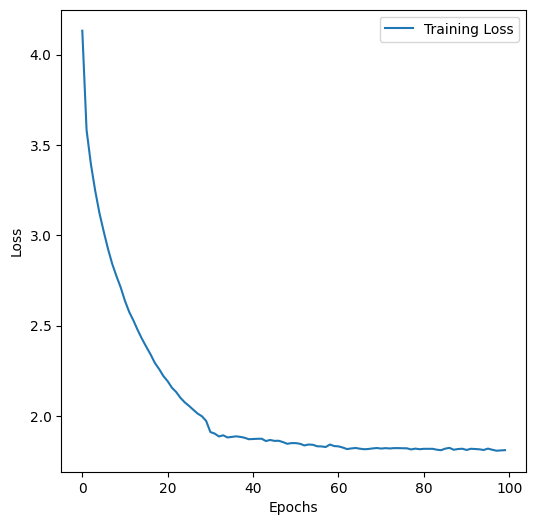

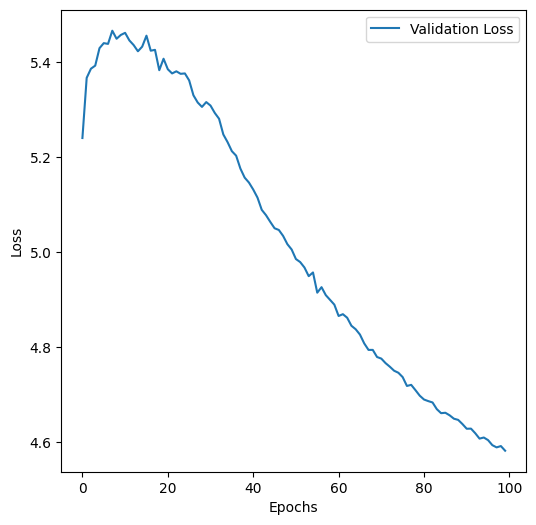

In [ ]:
encoder.eval()
decoder.eval()

plotTrainingLoss(trainingLossArray)
plotValidationLoss(validationLossArray)

#Saving Model

In [ ]:
torch.save(encoder.state_dict(), 'FrenchToEnglishEncoder.pth')
torch.save(decoder.state_dict(), 'FrenchToEnglishDecoder.pth')
with open('FrenchToEnglishEncoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)
with open('FrenchToEnglishDecoder.pkl', 'wb') as file:
    pickle.dump(decoder, file)

#Scores Evaluation

In [ ]:
nltk.download('wordnet')
def metricEvaluation(encoder, decoder, validationDataset, validationFrenchSentence, validationEnglishSentence, device):
    encoder.eval()
    decoder.eval()

    inputSentencesBleu = []
    outputSentencesBleu = []
    inputSentencesMeteor = []
    outputSentencesMeteor = []
    inputSentencesBert = []
    outputSentencesBert = []

    for frenchTensor, englishTensor in validationDataset:
        frenchTensor = frenchTensor.to(device).unsqueeze(0)
        englishTensor = englishTensor.to(device).unsqueeze(0)

        with torch.no_grad():
            encoderOutput, encoderHidden = encoder(frenchTensor)
            decoderOutput, _, _ = decoder(encoderOutput, encoderHidden, englishTensor)

        _, topi = decoderOutput.data.topk(1)
        outputSentences = [validationEnglishSentence['indexToCorrespondingWord'].get(token.item(), "") for token in topi.squeeze()]

        inputSentences = [validationEnglishSentence['indexToCorrespondingWord'].get(token.item(), "") for token in englishTensor.view(-1) if token.item() in validationEnglishSentence['indexToCorrespondingWord']]
        inputSentencesBleu.append([inputSentences])
        outputSentencesBleu.append(outputSentences)
        inputSentencesMeteor.append(inputSentences)
        outputSentencesMeteor.append(outputSentences)

        inputSentencesBert.append(' '.join(inputSentences))
        outputSentencesBert.append(' '.join(outputSentences))

    bleuScore = corpus_bleu(inputSentencesBleu, outputSentencesBleu)

    meteorScores = [meteor_score([cr], cc) for cr, cc in zip(inputSentencesMeteor, outputSentencesMeteor)]
    meteorScore = sum(meteorScores) / len(meteorScores)

    P, R, F1 = score(outputSentencesBert, inputSentencesBert, lang="en", verbose=True)
    bertPrecision = P.mean().item()
    bertRecall = R.mean().item()
    bertF1 = F1.mean().item()

    return bleuScore, meteorScore, bertF1, bertPrecision, bertRecall

bleuScore, meteorScore, bertF1, bertPrecision, bertRecall = metricEvaluation(encoder, decoder, validationDataset, validationFrenchSentence, validationEnglishSentence, device)

[nltk_data] Downloading package wordnet to /root/nltk_data...


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/641 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/326 [00:00<?, ?it/s]

done in 140.93 seconds, 147.78 sentences/sec


In [ ]:
print(f'Bleu Score: {bleuScore * 100:.2f}')
print(f'Meteor Score: {meteorScore * 100:.2f}')
print(f'Bert Recall: {bertRecall * 100:.2f}')
print(f'Bert Precision: {bertPrecision * 100:.2f}')
print(f'Bert F1: {bertF1 * 100:.2f}')

Bleu Score: 29.68
Meteor Score: 38.36
Bert Recall: 86.78
Bert Precision: 86.46
Bert F1: 86.61
